# Assignment 3

As before, if a question can be answered with 'yes/no', or a numeric value, you may simply state as much. If you incorporate code from the internet (which is not required and generally not advisable), please cite the source within your code (providing a URL is sufficient).

We will go through comparable code and concepts in the live learning session. If you run into trouble, start by using the help `help()` function in Python, to get information about the datasets and function in question. The internet is also a great resource when coding (though note that no outside searches are required by the assignment!). If you do incorporate code from the internet, please cite the source within your code (providing a URL is sufficient).

Please bring questions that you cannot work out on your own to office hours, work periods or share with your peers on Slack. We will work with you through the issue.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

### Question 1: Resampling via Bootstrapping

Now, we'll use the `iris` dataset, which we will add to Python using the `statsmodels` library. As always, start by reviewing a description of the dataset, by printing the dataset.

In [2]:
# Import
iris = sm.datasets.get_rdataset('iris', 'datasets')
df = pd.DataFrame(iris.data)
df

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


_(i)_ Create an `alpha_func(D, idx)` function which takes the `Sepal`'s `width` and `length` to calculate for alpha

In [4]:
# (i)

def alpha_func(D, idx):
    cov_ = np.cov(D[['Sepal.Length','Sepal.Width']].loc[idx], rowvar=False)
    return ((cov_[1,1] - cov_[0,1]) /
            (cov_[0,0]+cov_[1,1]-2*cov_[0,1]))

Test the code below

In [5]:
alpha_func(df, range(100))

0.38105014898343803

_(ii)_ Construct a new bootstrap data set and recompute alpha

In [8]:
rng = np.random.default_rng(0)
alpha_func(df,
           rng.choice(100,
                      100,
                      replace=True))

0.3324645134841774

Imagine we are analysts working for a shipping company. The company wants to know the average length of iris' petals, to inform space allotment on an upcoming shipment. The relevant variable in the dataset is `Sepal.Length`. 

_(iii)_ Why is it (perhaps) not sufficient to simply calculate the mean of `Sepal.Length`? What more information will preforming a bootstrap provide to us?  

_(iv)_ We can perform bootstrapping in Python by defining a simple function using `boot_SE()` for computing the bootstrap standard error. Remember, because bootstrapping involves randomness, we must first set a seed for reproducibility!

In [15]:
# (iii)
# Simply calculating the mean of Sepal.Length doesn't provide information on its variability or confidence interval
# We can use the bootstrap method to estimate the standard error of the mean

# (iv)
def boot_SE(func, D, n=None, B=1000, seed=0):
    rng = np.random.default_rng(seed)
    n = n or D.shape[0]
    bootstrap_values = []
    first_, second_ = 0, 0
    
    for _ in range(B):
        idx = rng.choice(D.index, n, replace=True)
        value = func(D, idx)
        bootstrap_values.append(value)
        first_ += value
        second_ += value**2
    
    # Calculate standard error
    standard_error = np.sqrt(second_ / B - (first_ / B)**2)
    return standard_error, np.array(bootstrap_values)

_(v)_ Evaluate the accuracy of our alpha estimate with B = 1000

In [16]:
# (v)
alpha_SE = boot_SE(alpha_func, df, B=1000)
alpha_SE

# A smaller standard error indicates a more precise estimate.
# If the standard error is large, it suggests that the alpha estimate has high variability and may not be very reliable.

(0.031805100768609415,
 array([0.18830059, 0.22389698, 0.20057469, 0.241568  , 0.24908259,
        0.24625543, 0.22111738, 0.26086624, 0.24980013, 0.23297294,
        0.23785601, 0.26233991, 0.20340398, 0.2768033 , 0.24047224,
        0.22786294, 0.20132126, 0.28068419, 0.22110996, 0.1970283 ,
        0.23865185, 0.28144986, 0.23050554, 0.19431813, 0.24656343,
        0.25199088, 0.25699606, 0.25288955, 0.2793997 , 0.2095195 ,
        0.27029546, 0.17969616, 0.23404509, 0.20387212, 0.20366089,
        0.28972734, 0.18079704, 0.23568555, 0.20957433, 0.24933915,
        0.29112109, 0.29844115, 0.25969873, 0.22912731, 0.22611141,
        0.22817939, 0.2633179 , 0.26059029, 0.20181064, 0.21466917,
        0.2755638 , 0.23279045, 0.20744557, 0.22660866, 0.20757392,
        0.2555327 , 0.24421578, 0.24914661, 0.29228482, 0.27604023,
        0.18168054, 0.26591079, 0.3080904 , 0.19458524, 0.23547472,
        0.29665115, 0.27797489, 0.21009949, 0.212537  , 0.28407616,
        0.32020426, 0.213

_(vi)_ What is the original mean value of `Sepal.Length`?

In [14]:
# (vi)
mean_sepal = df['Sepal.Length'].mean()
mean_sepal

5.843333333333334

Next, let's create a new bootstrapping to bootstrap samples (boot_se_samples) of Sepal.Length, in order to compute its bootstrapped mean and standard deviation.

(vii). Write code to review the bootstrapped mean value, and the standard deviation of the bootstrapped samples. Compare the mean against its original value. Then, review the bootstrapped range, by using t_range = np.ptp(boot_se_samples).

In [40]:
# (vii)

def bootstrap_sample_mean(data, n=None, B=1000, seed=0):
    rng = np.random.default_rng(seed)
    n = n or len(data)
    bootstrap_means = []

    for _ in range(B):
        sample = rng.choice(data, n, replace=True)
        bootstrap_means.append(np.mean(sample))

    bootstrap_means = np.array(bootstrap_means)
    bootstrapped_mean = np.array(np.mean(bootstrap_means))
    bootstrapped_std = np.std(bootstrap_means)
    t_range = np.ptp(bootstrap_means)

    return bootstrapped_mean, bootstrapped_std, t_range, bootstrap_means

sepal_length = df['Sepal.Length'].values

boot_mean, boot_std, t_range, boot_samples = bootstrap_sample_mean(sepal_length, B=1000, seed=0)

print(f"Bootstrapped mean: {boot_mean}")
print(f"Bootstrapped standard deviation: {boot_std}")
print(f"Range of bootstrapped means: {t_range}")


# Notes from work period session

# New line for saving bootstrapped samples
# Calculate bootstrap samples and standard deviation
# I need to create another bootstrap function that will return the standard deviation of the alpha values

Bootstrapped mean: 5.842284666666666
Bootstrapped standard deviation: 0.06649295592099295
Range of bootstrapped means: 0.3873333333333342


_(viii)_ Next, let's compute 95% confidence intervals, for the mean value of iris setal length. (Hint: use the `np.percentile` function)

In [55]:
# (viii)
lower_bound = np.percentile(boot_mean, 2.5)
upper_bound = np.percentile(boot_mean, 97.5)
conf_interval = np.percentile(boot_mean, [2.5, 97.5])

print("95-percent confidence interval for the mean of iris sepal length: ",lower_bound,upper_bound,conf_interval)

95-percent confidence interval for the mean of iris sepal length:  5.842284666666666 5.842284666666666 [5.84228467 5.84228467]


_(ix)_. Use the plot function to create an histogram of the bootstrapped samples. What does this histogram show ?

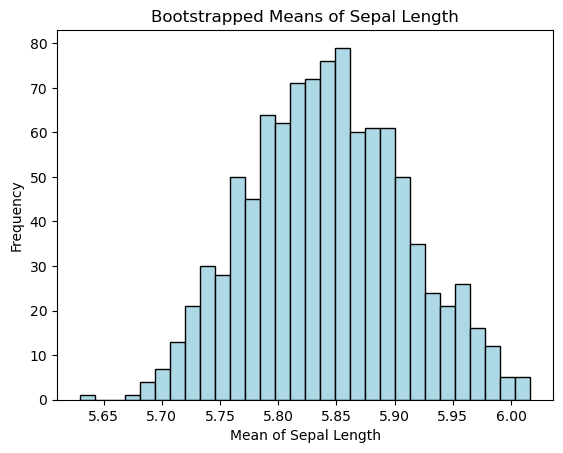

In [60]:
# (ix) Creating histogram of bootstrapped means

# Create a figure and axis
fig, ax = plt.subplots()

# Create the histogram
ax.hist(boot_samples, bins=30, edgecolor='black', color='lightblue')

# Add a title
ax.set_title('Bootstrapped Means of Sepal Length')

# Add a label to the x-axis
ax.set_xlabel('Mean of Sepal Length')

# Add a label to the y-axis
ax.set_ylabel('Frequency')

# Show the plot
plt.show()

_(x)_ Given your bootstrapped analysis, what do you recommend to shipping company? 

# (x)
According to the bootstrapped analysis, I would recommend the shipping company to plan for an average sepal length of approximately 5.8423 units when allocating space for the upcoming shipment. Confidence interval indicating the precision of the estimate and everythhing is supported by the bootstrap analysis. The narrow range of the confidence interval suggests high confidence in the estimated average sepal length. 

# Criteria

|Criteria            |Complete           |Incomplete          |
|--------------------|---------------|--------------|
|Bootstrapping|All steps are done correctly and the answers are correct.|At least one step is done incorrectly leading to a wrong answer.|

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Note:

If you like, you may collaborate with others in the cohort. If you choose to do so, please indicate with whom you have worked with in your pull request by tagging their GitHub username. Separate submissions are required.


### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/applied_statistical_concepts/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
